# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1) Load Data

In [2]:
train_dataset_path = 'data/train/'
validation_dataset_path = 'data/test/'

# 2) Augment the Images

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

### (i) Load the training data and augment

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 26120 images belonging to 135 classes.


### (ii) Load the validation data and augment

In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3138 images belonging to 135 classes.


### (iii) Get the label mapping

In [7]:
# Each number from 0-134 should match to a class of images (See csv file).
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 110
1 : 111
2 : 113
3 : 114
4 : 122
5 : 135
6 : 140
7 : 155
8 : 158
9 : 159
10 : 162
11 : 163
12 : 165
13 : 168
14 : 169
15 : 175
16 : 177
17 : 18
18 : 180
19 : 185
20 : 186
21 : 188
22 : 189
23 : 191
24 : 193
25 : 195
26 : 20
27 : 203
28 : 215
29 : 216
30 : 220
31 : 226
32 : 238
33 : 25
34 : 255
35 : 26
36 : 263
37 : 280
38 : 284
39 : 302
40 : 315
41 : 319
42 : 321
43 : 323
44 : 335
45 : 338
46 : 345
47 : 348
48 : 352
49 : 360
50 : 363
51 : 364
52 : 368
53 : 373
54 : 381
55 : 383
56 : 384
57 : 39
58 : 396
59 : 41
60 : 422
61 : 424
62 : 427
63 : 429
64 : 430
65 : 441
66 : 448
67 : 453
68 : 454
69 : 457
70 : 462
71 : 464
72 : 470
73 : 474
74 : 477
75 : 48
76 : 481
77 : 485
78 : 495
79 : 497
80 : 507
81 : 515
82 : 52
83 : 54
84 : 544
85 : 545
86 : 546
87 : 560
88 : 562
89 : 57
90 : 575
91 : 576
92 : 578
93 : 590
94 : 60
95 : 603
96 : 605
97 : 609
98 : 616
99 : 617
100 : 619
101 : 623
102 : 628
103 : 629
104 :

# 3) Plotting sample training images

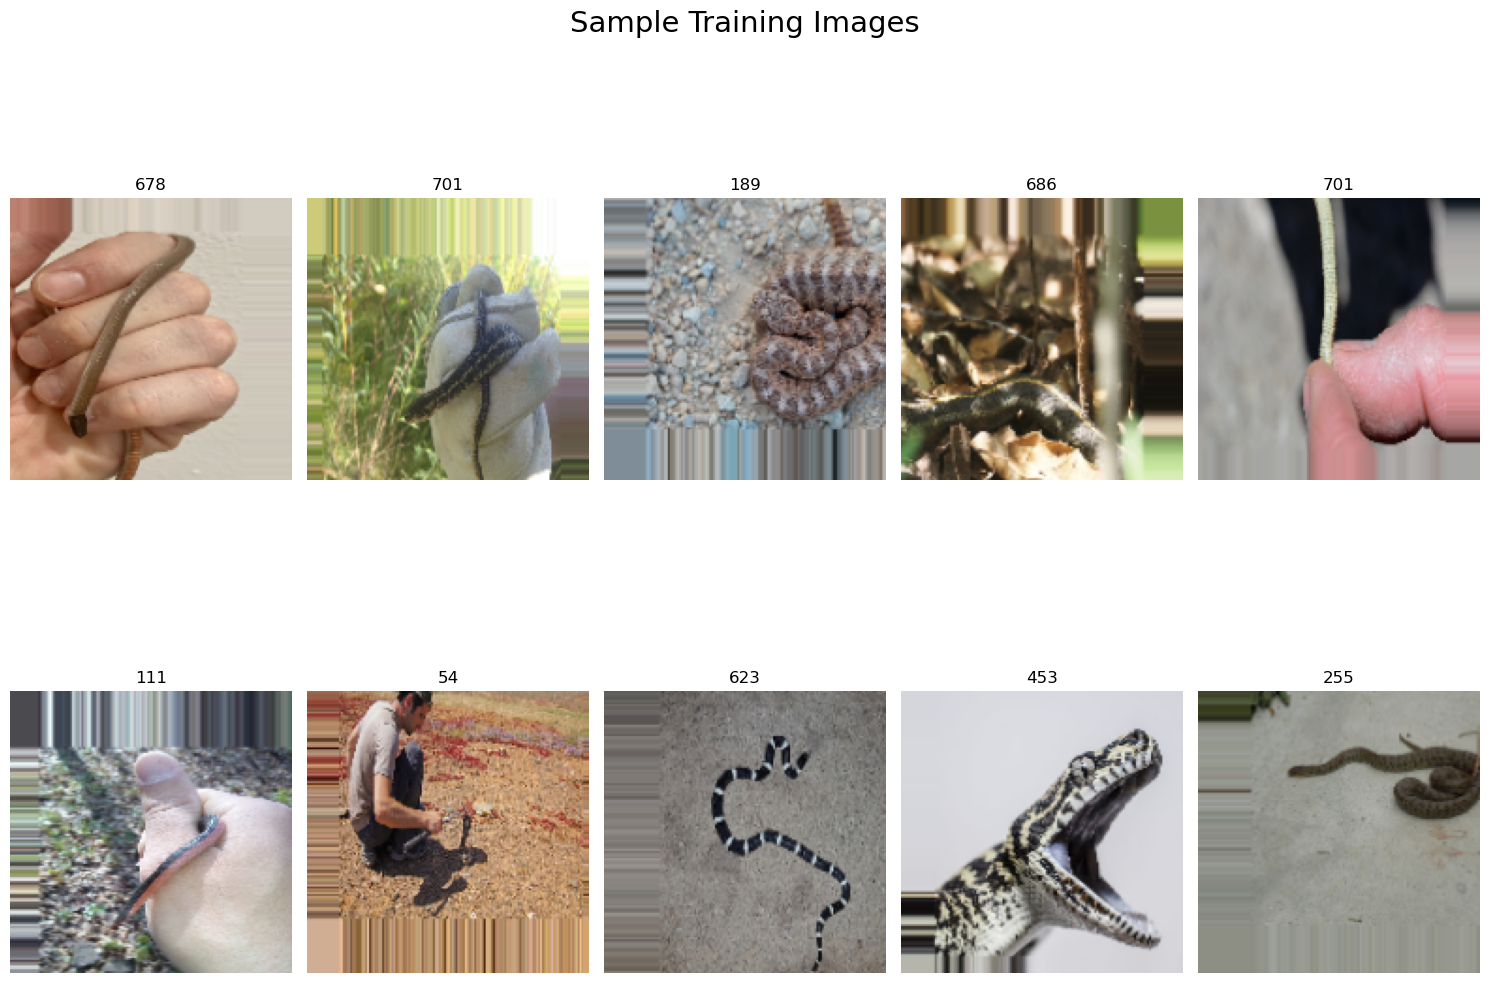

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# 4) Training the CNN model

### (i) Create the CNN model